# Predictive Analytics for the 2028 Summer Olympics

### Introduction
This script performs the analytical workflow used to support planning for the 2028 Summer Olympics. The objective is to extract insights from historical Olympic datasets, build a predictive model for athlete participation, and prepare data outputs for further visualisation in Tableau.

The analysis follows these key steps:

1. **Importing Libraries**  
   Essential Python libraries such as Pandas, NumPy, Matplotlib and Statsmodels are imported for data handling, visualisation and modelling.

2. **Loading and Cleaning the Dataset**  
   The raw CSV files are read, inspected, and cleaned to handle missing values, standardise formats and create usable analytical tables.

3. **Exploratory Data Analysis (EDA)**  
   Summary statistics, line charts and comparative plots are created to understand historical trends, gender patterns, and country-level participation.

4. **Regression Modelling (OLS Prediction for 2028)**  
   An OLS regression model is fitted to historical athlete participation.  
   - The model predicts the expected number of athletes in 2028.  
   - R-squared is calculated to evaluate model accuracy.

5. **Exporting Outputs**  
   Final cleaned datasets and prediction values are exported for use in the Tableau dashboard.

This Python analysis forms the statistical backbone of the project, ensuring that decisions are supported by quantified insights rather than assumptions.


### Importing all libraries


In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import statsmodels.api as sm

### Defining dataset names

In [7]:
# --- Define file names ---
bio_file = "Olympic_Athlete_Biography.csv"
details_file = "Olympic_Athlete_Event_Details.csv"
country_file = "Olympic_Country_Profiles.csv"
results_file = "Olympic_Event_Results.csv"
summary_file = "Olympic_Games_Summary.csv"
tally_file = "Olympic_Medal_Tally_History.csv"

In [8]:
# --- Load all datasets ---
athlete_bio_df = pd.read_csv(bio_file)
event_details_df = pd.read_csv(details_file)
country_profiles_df = pd.read_csv(country_file)
event_results_df = pd.read_csv(results_file)
games_summary_df = pd.read_csv(summary_file)
medal_tally_df = pd.read_csv(tally_file)
print("All datasets loaded successfully.")

All datasets loaded successfully.


#### 1. Clean and Export Medal Tally History

In [9]:
# Remove duplicates
medal_tally_df.drop_duplicates(inplace=True)

In [10]:
# Export to CSV 
medal_tally_output_path = "cleaned_olympic_medal_tally.csv"
medal_tally_df.to_csv(medal_tally_output_path, index=False)
    
print(f"\n[SUCCESS] Exported '{medal_tally_output_path}'")
print(f"Shape of medal tally data: {medal_tally_df.shape}")


[SUCCESS] Exported 'cleaned_olympic_medal_tally.csv'
Shape of medal tally data: (1807, 9)


#### 2. Cleaning Dataset


In [11]:
# Clean Event_Details
# Fill missing 'medal' values with 'No Medal'
event_details_df['medal'] = event_details_df['medal'].fillna('No Medal')
# Convert 'pos' (position) to numeric. Non-numeric values like 'DNS', 'AC' will become NaN.
event_details_df['pos'] = pd.to_numeric(event_details_df['pos'], errors='coerce')

In [12]:
# Clean Athlete_Biography
# Convert 'born' to datetime objects. Errors will become NaT (Not a Time).
athlete_bio_df['born'] = pd.to_datetime(athlete_bio_df['born'], errors='coerce')
# Convert 'weight' to numeric.
athlete_bio_df['weight'] = pd.to_numeric(athlete_bio_df['weight'], errors='coerce')
# Drop duplicates based on the primary key
athlete_bio_df.drop_duplicates(subset=['athlete_id'], inplace=True)

In [13]:
# Clean Country_Profiles by replacing the repeated country names
country_profiles_df['country'] = country_profiles_df['country'].replace({'Soviet Union': 'Russian Federation'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Russian Olympic Committee': 'Russian Federation'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'ROC': 'Russian Federation'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Unified Team': 'Russian Federation'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'East Germany': 'Germany'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'West Germany': 'Germany'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Saar': 'Germany'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Bohemia': 'Czechia'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Australasia': 'Australia'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Rhodesia': 'Zimbabwe'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'South Yemen': 'Yemen'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'North Yemen': 'Yemen'})
country_profiles_df['country'] = country_profiles_df['country'].replace({'Serbia and Montenegro': 'Serbia'})
country_profiles_df['country'] = country_profiles_df['country'].replace({"Democratic People's Republic of Korea": "Republic of Korea"})
country_profiles_df['country'] = country_profiles_df['country'].replace({"Korea Town": "Republic of Korea"})
country_profiles_df['country'] = country_profiles_df['country'].replace({'South Vietnam': 'Vietnam'})

In [14]:
# Clean Games_Summary
# Rename 'country_noc' to 'host_country_noc' to avoid collision on merge
games_summary_df.rename(columns={'country_noc': 'host_country_noc'}, inplace=True)

#### 3. Dataset Merging

In [15]:
# 1. Start with event_details (fact table)
# 2. Add games_summary info (year, city, host_country_noc)
merged_df = pd.merge(
event_details_df,
games_summary_df[['edition_id', 'year', 'city', 'host_country_noc']],
on='edition_id',
how='left'
)

In [16]:
# 3. Add athlete_bio info (name, sex, born, height, weight)
merged_df = pd.merge(
merged_df,
athlete_bio_df[['athlete_id', 'name', 'sex', 'born', 'height', 'weight']],
on='athlete_id',
how='left'
)

In [17]:
# 4. Add athlete's full country name from country_profiles
merged_df = pd.merge(
merged_df,
country_profiles_df,
left_on='country_noc',
right_on='noc',
how='left'
)

In [18]:
# 5. Add clean event_title from event_results
merged_df = pd.merge(
merged_df,
event_results_df[['result_id', 'event_title']],
on='result_id',
how='left'
)

#### 4. Calculate Athlete's Age at the event

In [19]:
if 'year' in merged_df.columns and 'born' in merged_df.columns:
        merged_df['age_at_event'] = merged_df['year'] - merged_df['born'].dt.year

In [20]:
# Create a simple 'is_medal_winner' flag (1 for yes, 0 for no)
merged_df['is_medal_winner'] = np.where(merged_df['medal'] == 'No Medal', 0, 1)

#### 5. Clean up and rename columns for final clarity in Tableau

In [21]:
# 3. Clean up and rename columns for final clarity in Tableau
final_columns = {
    'edition': 'edition_name',
    'edition_id': 'edition_id',
    'country_noc': 'athlete_country_noc',
    'sport': 'sport',
    'event_title': 'event_name', 
    'athlete_id': 'athlete_id',
    'name': 'athlete_name',
    'sex': 'athlete_sex',
    'age_at_event': 'athlete_age',
    'height': 'athlete_height',
    'weight': 'athlete_weight',
    'pos': 'position',
    'medal': 'medal_type',
    'isTeamSport': 'is_team_sport',
    'is_medal_winner': 'is_medal_winner',
    'year': 'olympic_year',
    'city': 'host_city',
    'host_country_noc': 'host_country_noc',
    'country': 'athlete_country_name' #
    }

In [22]:
# Select only the columns we want and rename them
# Filter columns to only those that exist in the merged_df
columns_to_select = [col for col in final_columns.keys() if col in merged_df.columns]
final_df = merged_df[columns_to_select].rename(columns=final_columns)
    
print(f"Final dataset created with {final_df.shape[1]} columns.")

Final dataset created with 19 columns.


#### 6. Export Final Dataset

In [23]:
# --- Export Final Merged Dataset ---
analysis_output_path = "cleaned_olympic_analysis_data.csv"
final_df.to_csv(analysis_output_path, index=False, encoding='utf-8')

#### 7. Predictive Analysis using OLS Regression

##### Using predictive modelling to predict the number of athletes in the 2028 Summer Olympics

In [4]:
df_details = pd.read_csv("cleaned_olympic_analysis_data.csv")

In [5]:
df_details.head()

,edition_name,edition_id,athlete_country_noc,sport,event_name,athlete_id,athlete_name,athlete_sex,athlete_age,athlete_height,athlete_weight,position,medal_type,is_team_sport,is_medal_winner,olympic_year,host_city,host_country_noc,athlete_country_name
0,1908 Summer Olympics,5,ANZ,Athletics,"100 metres, Men",64710,Ernest Hutcheon,Male,19.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
1,1908 Summer Olympics,5,ANZ,Athletics,"400 metres, Men",64756,Henry Murray,Male,22.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
2,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",64808,Harvey Sutton,Male,26.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
3,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",922519,Guy Haskins,Male,25.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
4,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",64735,Joseph Lynch,Male,30.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia


#### Filtering the dataset for Summer Olympics only

In [7]:
# Filter for Summer Olympics only using the 'edition_name' column
df_summer = df_details[df_details['edition_name'].str.contains('Summer Olympics')].copy()

# Use the existing 'olympic_year' column as the time base and rename it internally for consistency
df_summer.rename(columns={'olympic_year': 'Year'}, inplace=True)

# Group by Year and calculate the distinct count of athletes (our dependent variable, Y)
# The athlete ID column is correctly identified as 'athlete_id'
df_athletes = df_summer.groupby('Year')['athlete_id'].nunique().reset_index()
df_athletes.rename(columns={'athlete_id': 'Distinct Athletes'}, inplace=True)

In [8]:
df_summer.head()

,edition_name,edition_id,athlete_country_noc,sport,event_name,athlete_id,athlete_name,athlete_sex,athlete_age,athlete_height,athlete_weight,position,medal_type,is_team_sport,is_medal_winner,Year,host_city,host_country_noc,athlete_country_name
0,1908 Summer Olympics,5,ANZ,Athletics,"100 metres, Men",64710,Ernest Hutcheon,Male,19.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
1,1908 Summer Olympics,5,ANZ,Athletics,"400 metres, Men",64756,Henry Murray,Male,22.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
2,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",64808,Harvey Sutton,Male,26.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
3,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",922519,Guy Haskins,Male,25.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia
4,1908 Summer Olympics,5,ANZ,Athletics,"800 metres, Men",64735,Joseph Lynch,Male,30.0,NaN,NaN,NaN,No Medal,False,0,1908,London,GBR,Australia


In [11]:
df_athletes.head()

,Year,Distinct Athletes
0,1896,243
1,1900,2165
2,1904,1364
3,1908,2423
4,1912,2876


In [13]:
Y = df_athletes["Distinct Athletes"]
X = df_athletes["Year"]

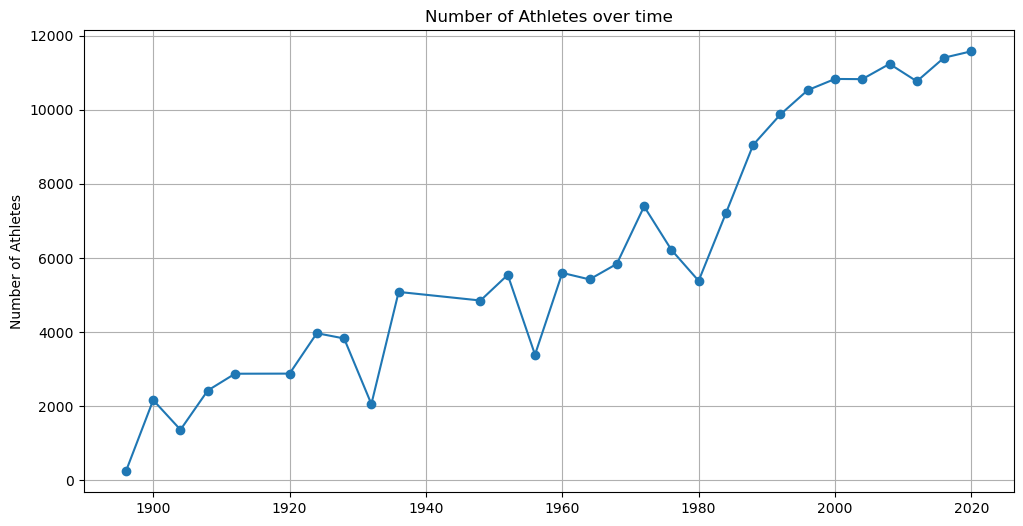

In [69]:
plt.figure(figsize=(12, 6))

plt.plot(df_athletes["Year"], df_athletes["Distinct Athletes"], marker="o")
plt.ylabel("Number of Athletes")
plt.title("Number of Athletes over time")
plt.grid(True)
plt.show()

In [18]:
correlation = X.corr(Y)
print("Correlation coefficient:", correlation)


Correlation coefficient: 0.9527657338590168


In [56]:
predictors = [
    "Year"
]

X = sm.add_constant(df_athletes[predictors])
Y = df_athletes["Distinct Athletes"]

In [57]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      Distinct Athletes   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     265.7
Date:                Wed, 05 Nov 2025   Prob (F-statistic):           1.69e-15
Time:                        00:16:50   Log-Likelihood:                -242.63
No. Observations:                  29   AIC:                             489.3
Df Residuals:                      27   BIC:                             492.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.636e+05   1.04e+04    -15.703      0.0

In [58]:
X.head()

,const,Year
0,1.0,1896
1,1.0,1900
2,1.0,1904
3,1.0,1908
4,1.0,1912


In [59]:
la_2028 = [1, 2028]
results.predict(la_2028)

array([12044.66053866])

#### Predicted Athletes: 12044